# Autoencoders

Un **autoencoder** es una arquitectura de red neuronal que nos permite comprimir la información. La arquitectura como tal es bastante simple, pues consta de una parte **codificadora** en la cual se conecta la entrada a una **capa densa** con un número de neuronas **sustancialmente menor** a la dimensionalidad de la entrada, y una parte **decodificadora** que conecta la capa densa a la salida, en la cual tendremos una dimensionalidad **igual** que la entrada.

<img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png" alt="Autoencoder de capa simple" width="400"/>

Esta arquitectura de **capa interna única** se puede generalizar añadiendo más capas, siempre y cuando las capas codificadoras tengan un **valor decreciente en el número de neuronas** para ir comprimiendo cada vez más la información, y un **número creciente** en las capas decodificadoras para ir deshaciendo la compresión de la información hasta alcanzar la dimensionalidad de la entrada.

Desde un punto de vista práctico, el efecto embudo produce que la red aprenda a representar la información de entrada con una dimensionalidad reducida, por lo tanto podemos utilizar los **autoencoders** como **modelos de reducción de dimensionalidad**. La clave está en utilizar **los mismos datos como variables de entrada y variables objetivo** durante el entrenamiento de la red.

## Caso de estudio: Fashion MNIST

Existe un conjunto de datos con la misma filosofía que MNIST, solo que en lugar de ser dígitos manuscritos se trata de fotografías de diferentes prendas de vestir. [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) ha sido publicado por la tienda de ropa *Zalando* como una mejora al clásico *dataset*.

Shape: (60000, 28, 28)
Training images: 60000
Image height: 28
Image width: 28


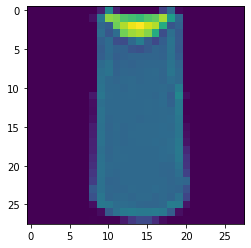

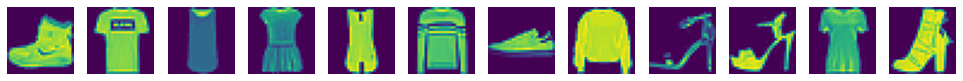

In [39]:
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

(X_train, y_test), (X_test, y_test) = fashion_mnist.load_data()

num_train_images = X_train.shape[0]
num_test_images = X_test.shape[0]
image_height = X_train.shape[1]
image_width = X_train.shape [2]

print("Shape: " + str(X_train.shape))
print("Training images: " + str(num_train_images))
print("Image height: " + str(image_height))
print("Image width: " + str(image_width))

plt.imshow(X_train[2])
fig, axs = plt.subplots(1,12, figsize=(17,6))
for i in range(12):
    axs[i].imshow(X_train[i])
    axs[i].axis('off')

Transformamos los valores de los píxeles al rango entre 0 y 1 y redimensionamos en `(n_samples, width * height)`

In [40]:
# Dense layer shape
X_train = X_train.reshape(X_train.shape[0], image_height*image_width)
X_test = X_test.reshape(X_test.shape[0], image_height*image_width)
X_train = X_train/255.0
X_test = X_test/255.0

Vamos a contruir un generador parametrizable de modelos que recibe el número de neuronas de la capa oculta del **autoencoder**. Los modelos devueltos por este generador serán **autoencoders de una capa**:

In [8]:
def make_one_layer_model(num_hidden_neurons):
    ins = K.Input(shape=(image_height*image_width,))
    densa = K.layers.Dense(num_hidden_neurons, activation='relu')(ins)
    outs = K.layers.Dense(image_height*image_width, activation='relu')(densa)
    model = K.Model(inputs=ins, outputs=outs, name='1-layer-autoencoder-'+str(num_hidden_neurons))
    return model

Vamos a comprobar la capacidad de compresión del **autoencoder** variando el número de neuronas de la capa oculta. El problema a resolver es un **problema de regresión**, puesto que hay que minimizar el error entre la salida (imagen reconstruida tras compresión) y la entrada (imagen original).

Definimos también la función para pintar la evolución de la función de coste y el *MAE*.

In [11]:
def plot_train_val(history):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    
    ax1.plot(history.history['loss'], label='loss (train)')
    ax1.plot(history.history['val_loss'], label='loss (val)')
    ax1.set_title('Loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax2.plot(history.history['mae'], label='mae (train)')
    ax2.plot(history.history['val_mae'], label='mae (val)')
    ax2.set_title('MAE')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax1.grid()
    ax2.grid()
    plt.plot()

Empezamos con un **autoencoder** de 100 neuronas en la capa oculta:

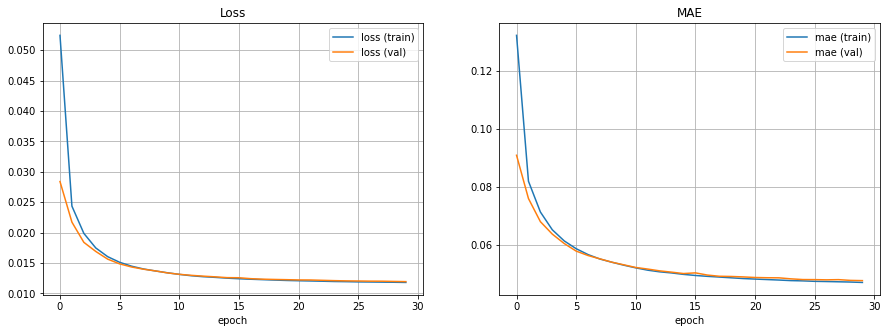

In [13]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    ae100 = make_one_layer_model(100)
    ae100.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_ae100 = ae100.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=30, batch_size=512, verbose=0)
plot_train_val(history_ae100)

Definimos una función para pintar una muestra aleatoria de imagenes reconstruidas por el **autoencoder** para ver qué tal lo está haciendo:

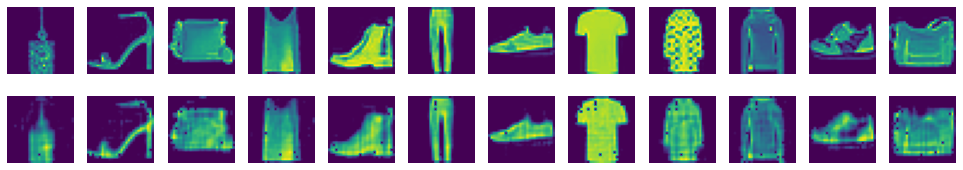

In [25]:
import numpy as np

def plot_rebuilt_sample(model, n_samples):
    idxs = np.random.choice(X_test.shape[0], n_samples, replace=False)
    sources = X_test[idxs, :]
    images = model.predict(
        sources.reshape(n_samples,image_height*image_width)
    ).reshape(n_samples, image_height, image_width)
    fig, axs = plt.subplots(2, n_samples, figsize=(17,3))
    for i in range(n_samples):
        axs[1, i].imshow(images[i, :])
        axs[1, i].axis('off')
        axs[0, i].imshow(sources[i, :].reshape(image_width, image_height))
        axs[0, i].axis('off')

plot_rebuilt_sample(ae100, 12)

Evaluemos el **autoencoder** con 50 capas ocultas

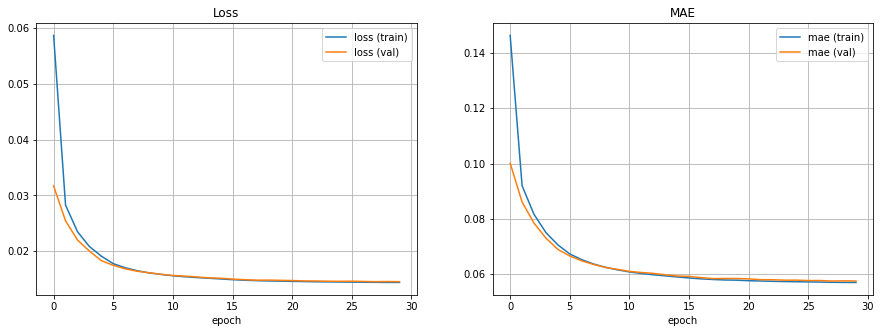

In [27]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    ae50 = make_one_layer_model(50)
    ae50.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_ae50 = ae50.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=30, batch_size=512, verbose=0)
plot_train_val(history_ae50)

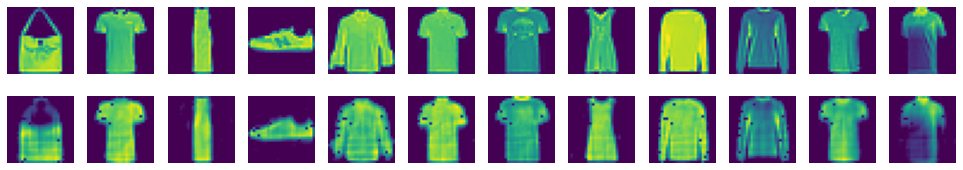

In [28]:
plot_rebuilt_sample(ae50, 12)

Como última prueba, vamos a realizar una compresión extrema entrenando un **autoencoder** de 8 neuronas ocultas:

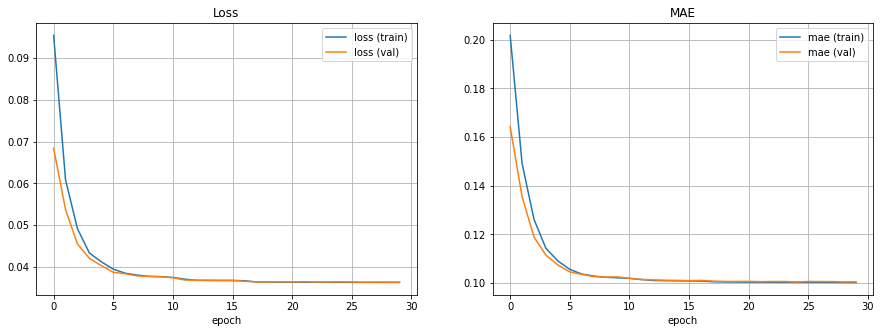

In [29]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    ae8 = make_one_layer_model(8)
    ae8.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_ae8 = ae8.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=30, batch_size=512, verbose=0)
plot_train_val(history_ae8)

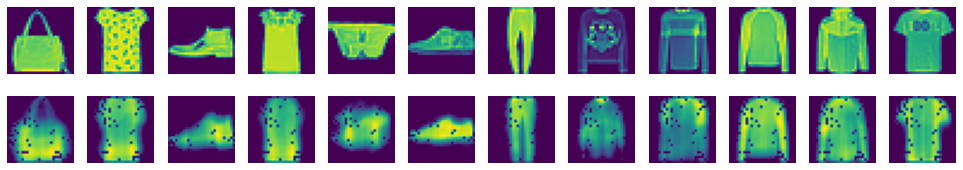

In [30]:
plot_rebuilt_sample(ae8, 12)

## Autoencoder multicapa

Como ya hemos dicho anteriormente, los **autoencoders** pueden estar formados por más de una capa interna para, de esta forma, poder obtener codificaciones de mayor nivel de abstracción que las capas ocultas menos internas.

Para comprobar la capacidad de reducción dimensional de esta arquitectura multicapa vamos a entrenarla con el conjunto de datos que hemos usado anteriormente. De esta forma podremos comparar los resultados de manera visual.

El generador recibirá como parámetro una secuencia del número de neuronas que tendrá cada capa de la parte codificadora, la cual se replicará en orden inverso para la capa decodificadora.

In [38]:
def make_multilayer_autoencoder(n_neurons):
    ins = K.Input(shape=(image_height*image_width,))
    densa = K.layers.Dense(n_neurons[0], activation='relu')(ins)
    
    # Codificador
    for n in n_neurons[1:]:
        densa = K.layers.Dense(n, activation='relu')(densa)
    # Decodificador
    for n in list(reversed(n_neurons))[1:]:
        densa = K.layers.Dense(n, activation='relu')(densa)
    
    outs = K.layers.Dense(image_height*image_width, activation='relu')(densa)
    model = K.Model(inputs=ins, outputs=outs, name=str(2*len(n_neurons)-1)+'-layers-autoencoder')
    return model

In [39]:
make_multilayer_autoencoder([50,20,10]).summary()

Model: "5-layers-autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_18 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_21 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_22 (Dense)             (None, 784)      

Vamos a comprobar el rendimiento de un **autoencoder** de 3 capas:

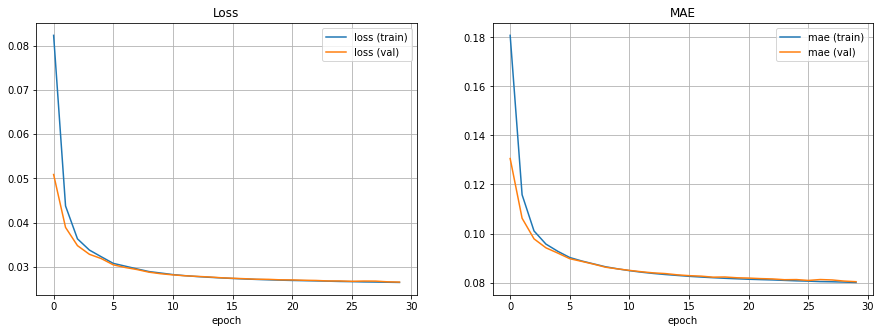

In [40]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    ae3layer = make_multilayer_autoencoder([32, 16])
    ae3layer.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_ae3layer = ae3layer.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=30, batch_size=512, verbose=0)
plot_train_val(history_ae3layer)

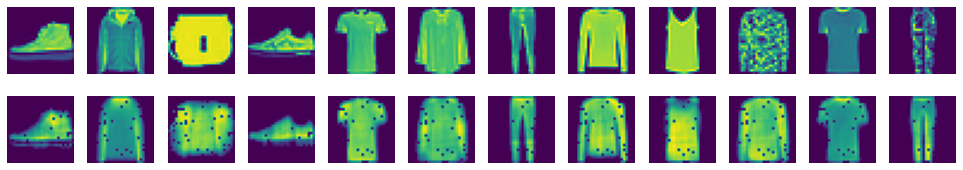

In [41]:
plot_rebuilt_sample(ae3layer, 12)

Y también un modelo multicapa con 5 capas internas:

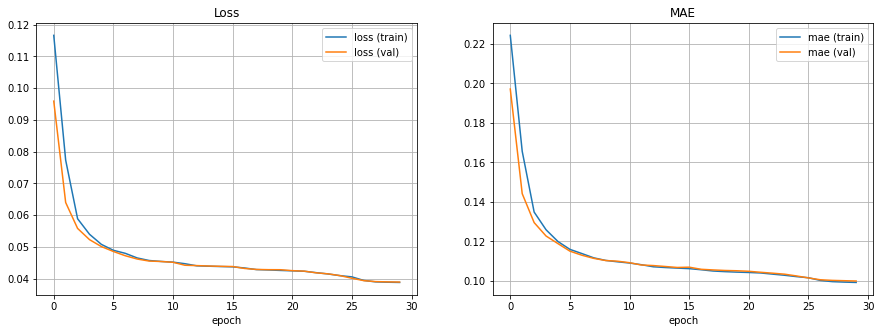

In [42]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    ae5layer = make_multilayer_autoencoder([32, 16, 8])
    ae5layer.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_ae5layer = ae5layer.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=30, batch_size=512, verbose=0)
plot_train_val(history_ae5layer)

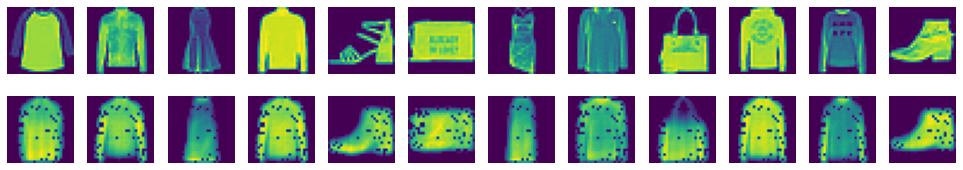

In [44]:
plot_rebuilt_sample(ae5layer, 12)

## Autoencoders convolucionales
Las redes convolucionales funcionan muy bien para el procesamiento de imágenes. Podríamos combinar la capacidad de las redes comvolucionales para el tratamiento de imágenes con la reducción dimensional que proporcionan los **autoencoders** construyendo una arquitectura que combine ambas.

Un autoencoder convolucional constará de varias capas convolucionales de tamaño cada vez más pequeño, que hará las veces de codificador. Si la dimensionalidad sigue siendo muy alta, se puede enganchar un **autoencoder** a la salida de las capas convolucionales. Por último, habrá que deshacer la codificación encadenando diversas capas *deconvolution* y *unpooling* de tamaños crecientes.

In [48]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Conv2DTranspose, Reshape

def make_conv_autoencoder():
    model = K.Sequential()
    model.add(Conv2D(16, (3,3), input_shape=(28, 28, 1),
              activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='pool1'))
    model.add(Conv2D(8, (3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='pool2'))
    model.add(Conv2D(4, (3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='pool3'))
    model.add(Flatten(name='flatten'))
    model.add(Reshape((3,3,4)))
    model.add(Conv2DTranspose(4, kernel_size = (5,5), activation='relu'))
    model.add(Conv2DTranspose(8, kernel_size = (8,8), activation='relu'))
    model.add(Conv2DTranspose(16, kernel_size = (15,15), activation='relu'))
    model.add(Conv2D(1, (3, 3), activation='relu',padding='same'))
    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 3, 3, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0

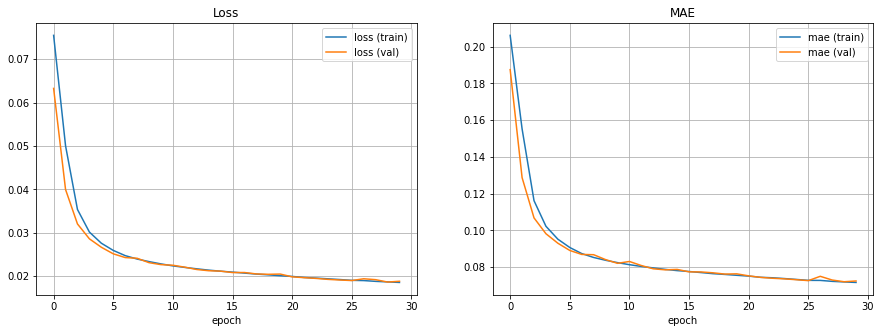

In [50]:
X_train_c = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_c = X_test.reshape(X_test.shape[0], 28, 28, 1)

with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    convo = make_conv_autoencoder()
    convo.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_convo = convo.fit(X_train_c, X_train_c, validation_data=(X_test_c, X_test_c),
                        epochs=30, batch_size=512, verbose=0)
plot_train_val(history_convo)

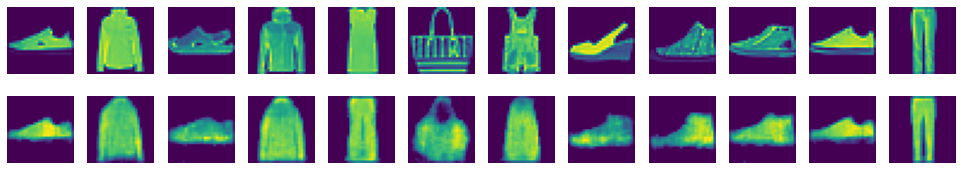

In [53]:
idxs = np.random.choice(X_test_c.shape[0], 12, replace=False)
sources = X_test_c[idxs, :]
images = convo.predict(sources).reshape(12, image_height, image_width)
fig, axs = plt.subplots(2, 12, figsize=(17,3))
for i in range(12):
    axs[1, i].imshow(images[i, :])
    axs[1, i].axis('off')
    axs[0, i].imshow(sources[i, :].reshape(image_width, image_height))
    axs[0, i].axis('off')

## Autoencoders como reducción dimensional

Como ya hemos visto, los **autoencoders** son un mecanismo de reducción dimensional. Por lo tanto, podemos usarlos para representar gráficamente conjuntos de datos con muchas dimensiones aplicando **autoencoders** para reducir el problema a dos o tres dimensiones y así poder representar la información gráficamente.

Vamos a intentar representar en una imagen en 2D todas las muestras del dataset **Fashion MNIS**, las cuales tienen 784 variables. Para ello, vamos a usar la arquitectura convolucional anterior y añadiremos un par de capas densas en la zona central de la arquitectura: una de dos neuronas para determinar la posición de la muestra en el gráfico en 2D, y otra de $3\times 3\times 4$ para enganchar con la siguiente capa `Reshape` de dimensiones `(3, 3, 4)`.

In [55]:
def make_conv_2D():
    model = K.Sequential()
    model.add(Conv2D(16, (3,3), input_shape=(28, 28,1),
              activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='pool1'))
    model.add(Conv2D(8, (3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='pool2'))
    model.add(Conv2D(4, (3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='pool3'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(2, input_dim=3*3*4, activation='relu'))
    model.add(Dense(3*3*4, activation='relu'))
    model.add(Reshape((3,3,4)))
    model.add(Conv2DTranspose(4, kernel_size = (5,5), activation='relu'))
    model.add(Conv2DTranspose(8, kernel_size = (8,8), activation='relu'))
    model.add(Conv2DTranspose(16, kernel_size = (15,15), activation='relu'))
    model.add(Conv2D(1, (3, 3), activation='relu',padding='same'))
    return model

Cada vez que introducimos una imagen en la red conseguimos resultados en los mapas de activación. Cada muestra de entrada genera un mapa de activación en la capa oculta de 2 neuronas. Tenemos que obtener dicho mapa de activación de alguna forma, así que lo que hacemos es entrenar el modelo y, posteriormente, crear un nuevo modelo a partir del ya entrenado cuya salida es la salidad de la capa `Dense` con las dos neuronas:

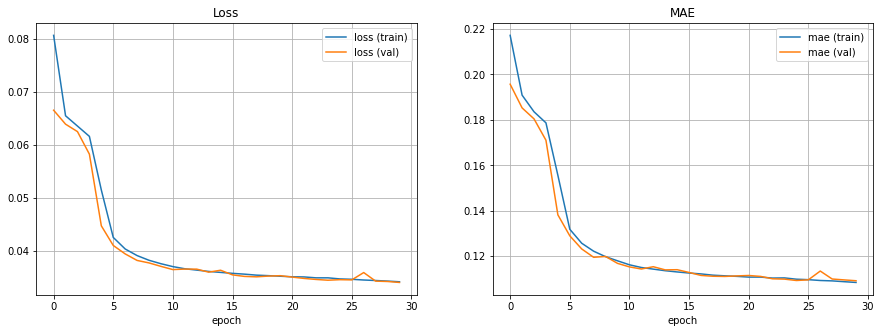

In [65]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    convo_2d = make_conv_2D()
    convo_2d.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_convo_2d = convo_2d.fit(X_train_c, X_train_c, validation_data=(X_test_c, X_test_c),
                        epochs=30, batch_size=512, verbose=0)
plot_train_val(history_convo_2d)

(10000, 2)
(10000,)


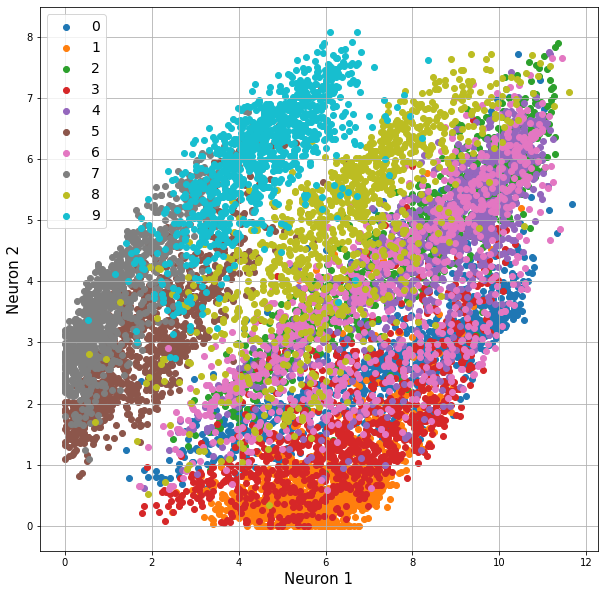

In [66]:
model_to_draw2D = K.Model(
    inputs=convo_2d.input,
    outputs=convo_2d.layers[7].output
)
intermediate_output = model_to_draw2D.predict(X_test_c)
print(intermediate_output.shape)
print(y_test.shape)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(
        intermediate_output[y_test==i,0],
        intermediate_output[y_test==i,1], 
        marker='o', 
        label= format(i)
)
plt.xlabel('Neuron 1', fontsize=15)
plt.ylabel('Neuron 2', fontsize=15)
plt.legend(prop={'size':14}); plt.grid();
plt.grid(True)
plt.show()

Aunque se observa como la red consigue agrupar las muestras de cada número, con un *bottleneck* tan estricto no existe una adecuada separación entre clases. Para mejorar la separación, vamos a utilizar un autoencoder denso de tres capas, con la capa más interna de tres neuronas para dibujar un gráfico tridimensional. Las otras dos capas del autoencoder se han diseñado con 64 neuronas.

In [69]:
def make_autoencoder_3D():
    ins = K.Input(shape=(28*28,))
    dense = Dense(64, activation='relu')(ins)
    dense = Dense(3, activation='relu')(dense)
    dense = Dense(64, activation='relu')(dense)
    outs = Dense(28*28, activation='relu')(dense)
    
    return K.Model(inputs=ins, outputs=outs)

In [75]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    convo_3d = make_autoencoder_3D()
    convo_3d.compile(
        loss='mse', 
        optimizer='adam', metrics=['mae'])
    history_convo_3d = convo_3d.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=50, batch_size=512, verbose=0)
plot_train_val(history_convo_3d)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

model_to_draw3D = K.Model(
    inputs=convo_3d.input,
    outputs=convo_3d.layers[1].output)
int_out = model_to_draw3D.predict(X_test)
print(int_out.shape)

fig = plt.figure(figsize=(7, 7))
axs = Axes3D(fig, elev=10, azim=-70)
for i in range(10):
    axs.scatter(
        int_out[y_test==i,0], 
        int_out[y_test==i,1],
        int_out[y_test==i,2], 
        marker='.')
axs.set_xlabel('Neuron 1', fontsize=18)
axs.set_ylabel('Neuron 2', fontsize=18)
axs.set_zlabel('Neuron 3', fontsize=18)
axs.grid()
plt.show()

(10000, 64)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

---

Creado por **Raúl Lara Cabrera** (raul.lara@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">